In [1]:
# 0) Imports & optional installs
# ----------------------------
import os, random, sys, subprocess, warnings, math, time
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
plt.rcParams["figure.dpi"] = 120

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import transforms, datasets
from torchvision.utils import make_grid
from PIL import Image

from sklearn.metrics import (accuracy_score, confusion_matrix, classification_report,
                             roc_curve, auc)
from sklearn.preprocessing import label_binarize

# timm for Swin
import timm

# try to import umap & shap; install if missing (Kaggle usually allows pip)
try:
    import umap
except Exception:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "umap-learn"])
    import umap

try:
    import shap
except Exception:
    try:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "shap"])
        import shap
    except Exception:
        shap = None


2025-09-04 08:24:20.213518: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756974260.428934      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756974260.489466      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# 1) Reproducibility & device
# ----------------------------
SEED = 42
def set_seed(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [3]:
# 2) Paths (Kaggle dataset)
# ----------------------------
TRAIN_DIR = "/kaggle/input/brain-tumor-mri-dataset/Training"
TEST_DIR  = "/kaggle/input/brain-tumor-mri-dataset/Testing"

assert os.path.exists(TRAIN_DIR), f"Training path does not exist: {TRAIN_DIR}"
assert os.path.exists(TEST_DIR),  f"Testing path does not exist: {TEST_DIR}"

In [4]:
# 3) Transforms & Dataset
# ----------------------------
IMG_SIZE = 224
BATCH_SIZE = 32
NUM_WORKERS = 2

IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.12, contrast=0.12),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

train_dataset = datasets.ImageFolder(TRAIN_DIR, transform=train_transform)
test_dataset  = datasets.ImageFolder(TEST_DIR,  transform=test_transform)
class_names = train_dataset.classes
num_classes = len(class_names)
print("Classes:", class_names)
print("Train samples:", len(train_dataset), "Test samples:", len(test_dataset))

Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']
Train samples: 5712 Test samples: 1311


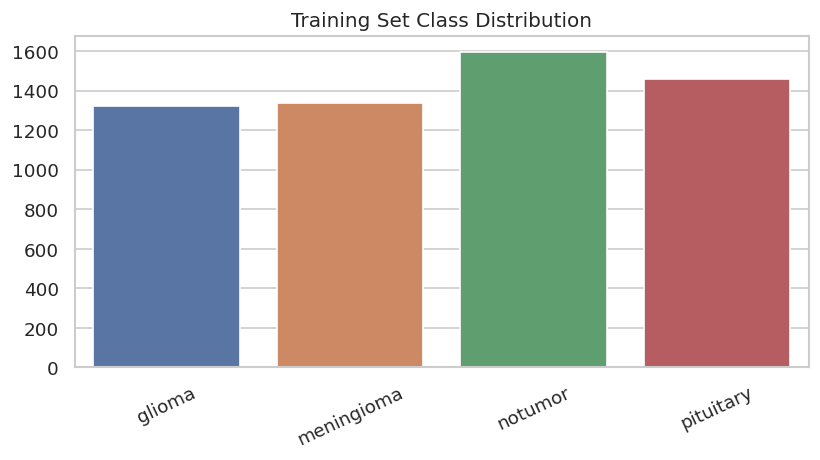

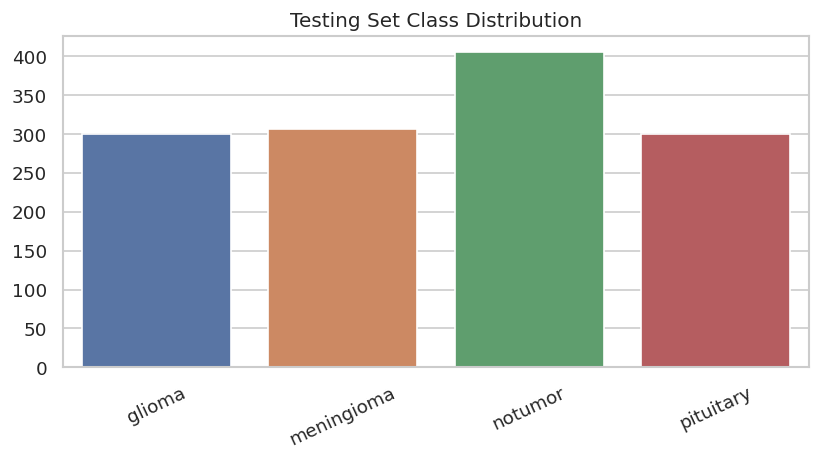

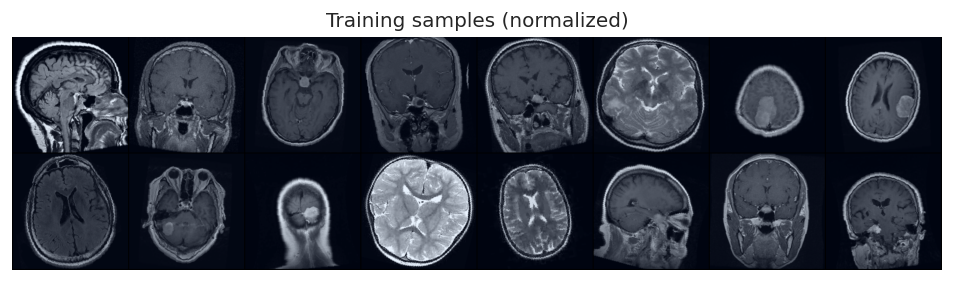

In [5]:
# 4) Quick EDA Visualizations
# ----------------------------
def plot_class_distribution(dataset, title="Class Distribution"):
    targets = np.array(dataset.targets)
    labels, counts = np.unique(targets, return_counts=True)
    plt.figure(figsize=(7,4))
    sns.barplot(x=[dataset.classes[i] for i in labels], y=counts)
    plt.title(title); plt.xticks(rotation=25); plt.tight_layout(); plt.show()

plot_class_distribution(train_dataset, "Training Set Class Distribution")
plot_class_distribution(test_dataset,  "Testing Set Class Distribution")

# show a normalized training batch grid
def show_grid(loader, n=16, title="Sample Grid"):
    imgs, labs = next(iter(loader))
    grid = make_grid(imgs[:n], nrow=8, normalize=True)
    plt.figure(figsize=(10,4)); plt.imshow(np.transpose(grid.cpu().numpy(), (1,2,0))); plt.title(title); plt.axis("off"); plt.show()

# Temporary DataLoader for visualization (no sampler)
viz_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=NUM_WORKERS)
show_grid(viz_loader, n=16, title="Training samples (normalized)")

In [6]:
# 5) Balanced Sampler & class weights
# ----------------------------
train_targets = np.array(train_dataset.targets)
class_counts = np.bincount(train_targets, minlength=num_classes)
total_train = len(train_dataset)
print("Train class counts:", dict(enumerate(class_counts)))

# inverse frequency class weights
class_weights = total_train / (num_classes * (class_counts + 1e-12))
print("Class weights (inverse freq):", {class_names[i]: float(class_weights[i]) for i in range(num_classes)})

sample_weights = class_weights[train_targets]
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler,
                          num_workers=NUM_WORKERS, pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=True)

# Show one balanced batch counts
imgs_b, lbls_b = next(iter(train_loader))
from collections import Counter
print("Balanced batch label counts:", dict(Counter(lbls_b.numpy())))

# ----------------------------

Train class counts: {0: 1321, 1: 1339, 2: 1595, 3: 1457}
Class weights (inverse freq): {'glioma': 1.0809992429977282, 'meningioma': 1.066467513069454, 'notumor': 0.8952978056426327, 'pituitary': 0.9800960878517495}
Balanced batch label counts: {0: 12, 2: 6, 1: 9, 3: 5}


In [7]:
# 6) Model factory
# ----------------------------
def get_model(n_classes):
    model = timm.create_model("swin_tiny_patch4_window7_224", pretrained=True, num_classes=n_classes)
    return model

# ---------------------------

In [8]:
# 7) Train & Eval helpers
# ----------------------------
def train_one_epoch(model, loader, criterion, optimizer):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for imgs, labels in loader:
        imgs, labels = imgs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        running_loss += loss.item() * imgs.size(0)
        preds = outputs.argmax(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    return running_loss/total, correct/total

@torch.no_grad()
def evaluate(model, loader, criterion):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    all_true, all_pred, all_prob = [], [], []
    for imgs, labels in loader:
        imgs, labels = imgs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        running_loss += loss.item() * imgs.size(0)
        probs = torch.softmax(outputs, dim=1)
        preds = outputs.argmax(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        all_true.extend(labels.cpu().numpy())
        all_pred.extend(preds.cpu().numpy())
        all_prob.extend(probs.cpu().numpy())
    return running_loss/total, correct/total, np.array(all_true), np.array(all_pred), np.array(all_prob)

def plot_training_curves(history):
    epochs = range(1, len(history["train_loss"])+1)
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(epochs, history["train_loss"], label="Train Loss")
    plt.plot(epochs, history["val_loss"], label="Val Loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Loss"); plt.legend(); plt.grid(True)
    plt.subplot(1,2,2)
    plt.plot(epochs, np.array(history["train_acc"])*100, label="Train Acc")
    plt.plot(epochs, np.array(history["val_acc"])*100, label="Val Acc")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy (%)"); plt.title("Accuracy"); plt.legend(); plt.grid(True)
    plt.tight_layout(); plt.show()

def plot_confusion_and_report(y_true, y_pred, class_names, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    cmn = cm.astype('float') / (cm.sum(axis=1, keepdims=True) + 1e-12)
    plt.figure(figsize=(6,5))
    sns.heatmap(cmn, annot=True, fmt=".2f", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted"); plt.ylabel("True"); plt.title(title); plt.tight_layout(); plt.show()
    print("Classification report:\n", classification_report(y_true, y_pred, target_names=class_names, digits=4))

def plot_roc_multi(y_true, y_prob, class_names, title="ROC (OvR)"):
    y_true_bin = label_binarize(y_true, classes=list(range(len(class_names))))
    plt.figure(figsize=(7,6))
    for i, cls in enumerate(class_names):
        try:
            fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f"{cls} (AUC={roc_auc:.3f})")
        except Exception:
            pass
    plt.plot([0,1],[0,1],'k--'); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title(title); plt.legend(); plt.grid(True); plt.show()


model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]

Epoch 1/12 | Train Loss: 0.3373 Train Acc: 0.8780 | Val Loss: 0.1402 Val Acc: 0.9535
Epoch 2/12 | Train Loss: 0.1072 Train Acc: 0.9634 | Val Loss: 0.1600 Val Acc: 0.9527
Epoch 3/12 | Train Loss: 0.0762 Train Acc: 0.9748 | Val Loss: 0.0583 Val Acc: 0.9863
Epoch 4/12 | Train Loss: 0.0507 Train Acc: 0.9837 | Val Loss: 0.0408 Val Acc: 0.9886
Epoch 5/12 | Train Loss: 0.0272 Train Acc: 0.9919 | Val Loss: 0.0581 Val Acc: 0.9878
Epoch 6/12 | Train Loss: 0.0282 Train Acc: 0.9918 | Val Loss: 0.0583 Val Acc: 0.9908
Epoch 7/12 | Train Loss: 0.0221 Train Acc: 0.9939 | Val Loss: 0.0331 Val Acc: 0.9954
Epoch 8/12 | Train Loss: 0.0135 Train Acc: 0.9961 | Val Loss: 0.0280 Val Acc: 0.9969
Epoch 9/12 | Train Loss: 0.0109 Train Acc: 0.9977 | Val Loss: 0.0344 Val Acc: 0.9962
Epoch 10/12 | Train Loss: 0.0127 Train Acc: 0.9965 | Val Loss: 0.0320 Val Acc: 0.9962
Epoch 11/12 | Train Loss: 0.0078 Train Acc: 0.9974 | Val Loss: 0.0367 Val Acc: 0.9962
Epoch 12/12 | Train Loss: 0.0108 Train Acc: 0.9970 | Val Loss: 

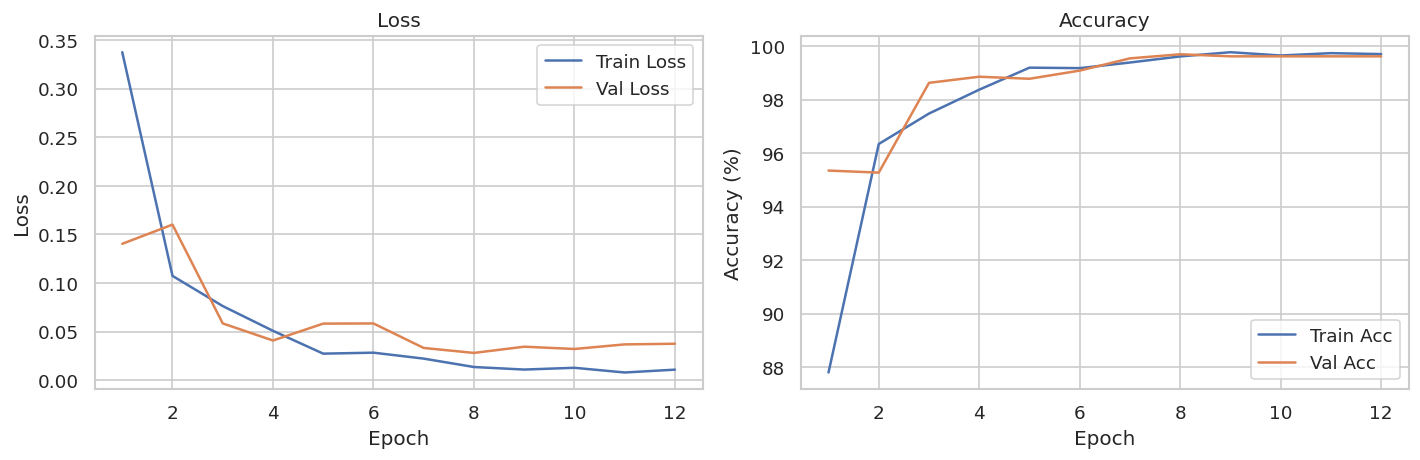

In [9]:
# 8) Training configuration (balanced + class-weighted loss)
# ----------------------------
set_seed(SEED)
model = get_model(num_classes).to(device)

# class weights (for loss)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = optim.AdamW(model.parameters(), lr=3e-5, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=12)

EPOCHS = 12
history = {"train_loss":[], "train_acc":[], "val_loss":[], "val_acc":[]}
best_val_acc = 0.0
best_state = None

for ep in range(1, EPOCHS+1):
    tr_loss, tr_acc = train_one_epoch(model, train_loader, criterion, optimizer)
    val_loss, val_acc, y_true_v, y_pred_v, y_prob_v = evaluate(model, test_loader, criterion)

    history["train_loss"].append(tr_loss)
    history["train_acc"].append(tr_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    print(f"Epoch {ep}/{EPOCHS} | Train Loss: {tr_loss:.4f} Train Acc: {tr_acc:.4f} | Val Loss: {val_loss:.4f} Val Acc: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_state = {'model': model.state_dict(), 'epoch': ep, 'val_acc': val_acc}

    scheduler.step()

# save best checkpoint
if best_state is not None:
    CKPT = "best_swin_tiny_224_seed42_balanced.pth"
    torch.save(best_state['model'], CKPT)
    print("Saved best checkpoint:", CKPT, "epoch:", best_state['epoch'], "val_acc:", best_state['val_acc'])
else:
    CKPT = None
    print("No best state saved (unexpected)")

plot_training_curves(history)


Final Eval -> Val Loss: 0.0374, Val Acc: 0.9962


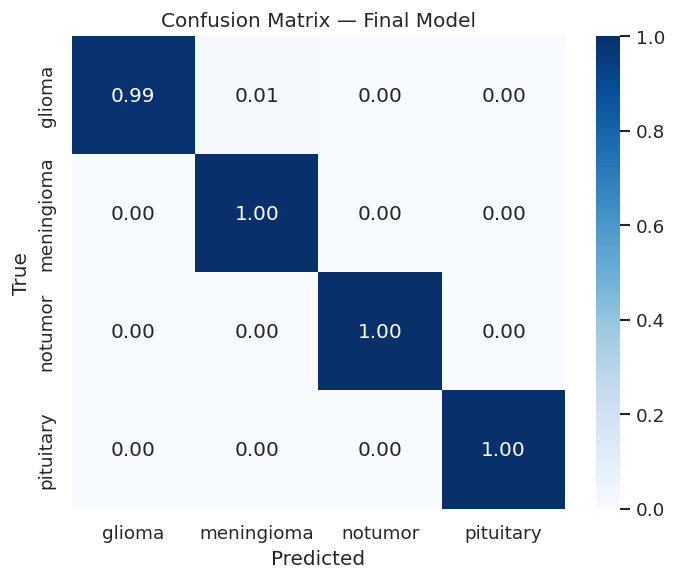

Classification report:
               precision    recall  f1-score   support

      glioma     1.0000    0.9867    0.9933       300
  meningioma     0.9839    1.0000    0.9919       306
     notumor     1.0000    1.0000    1.0000       405
   pituitary     1.0000    0.9967    0.9983       300

    accuracy                         0.9962      1311
   macro avg     0.9960    0.9958    0.9959      1311
weighted avg     0.9962    0.9962    0.9962      1311



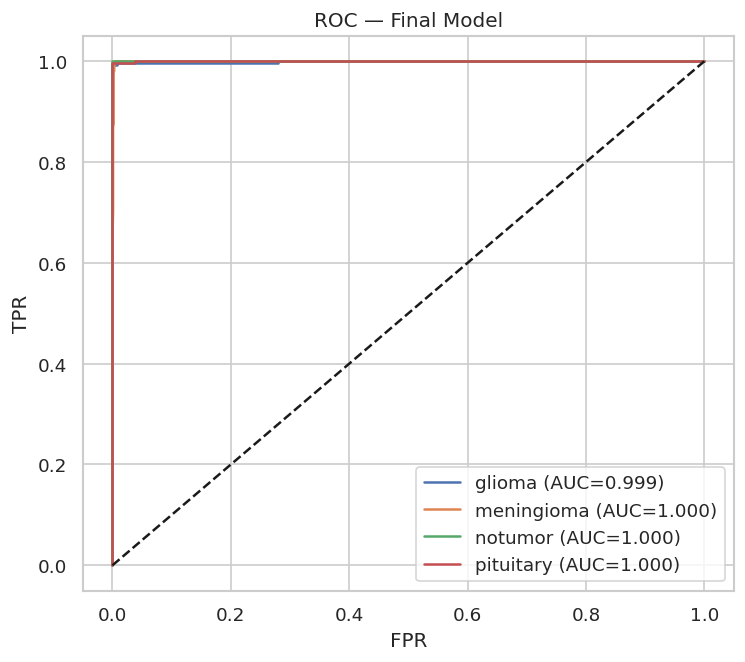

In [10]:
# ----------------------------
# 9) Load best model & final evaluation
# ----------------------------
final_model = get_model(num_classes).to(device)
if CKPT is not None:
    final_model.load_state_dict(torch.load(CKPT, map_location=device))
final_model.eval()

val_loss, val_acc, y_true, y_pred, y_prob = evaluate(final_model, test_loader, criterion)
print(f"Final Eval -> Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

plot_confusion_and_report(y_true, y_pred, class_names, title="Confusion Matrix — Final Model")
plot_roc_multi(y_true, y_prob, class_names, title="ROC — Final Model")


In [11]:
# print classification report
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))


              precision    recall  f1-score   support

      glioma     1.0000    0.9867    0.9933       300
  meningioma     0.9839    1.0000    0.9919       306
     notumor     1.0000    1.0000    1.0000       405
   pituitary     1.0000    0.9967    0.9983       300

    accuracy                         0.9962      1311
   macro avg     0.9960    0.9958    0.9959      1311
weighted avg     0.9962    0.9962    0.9962      1311



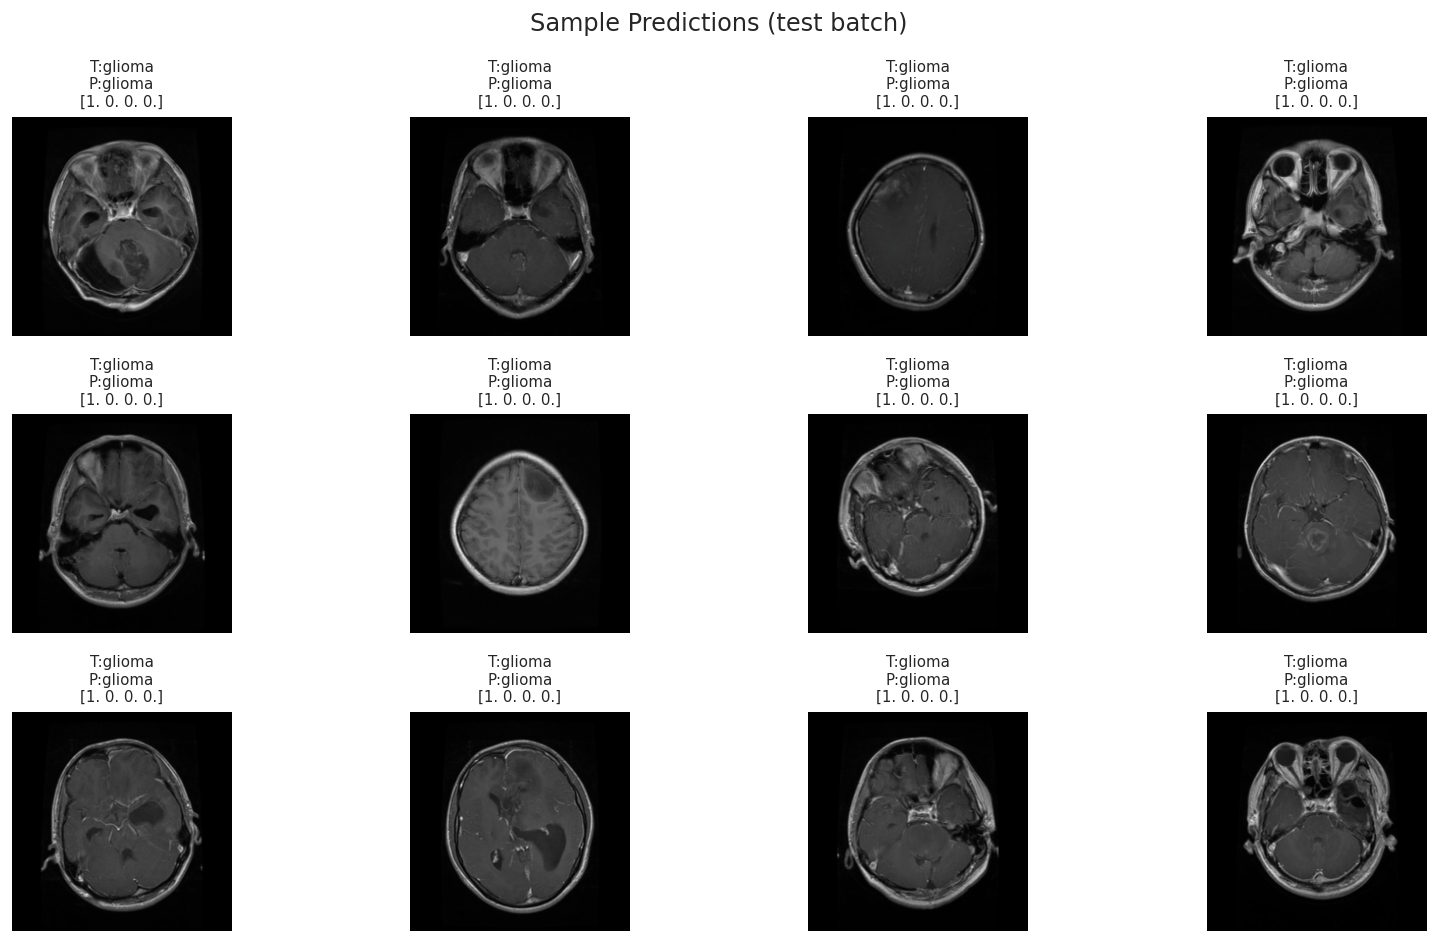

In [12]:
# 10) Show sample predictions with probabilities
# ----------------------------
imgs_batch, labels_batch = next(iter(test_loader))
imgs_check = imgs_batch[:12].to(device)
labs_check = labels_batch[:12].numpy()
with torch.no_grad():
    out_check = final_model(imgs_check)
    probs_check = torch.softmax(out_check, dim=1).cpu().numpy()
    preds_check = out_check.argmax(1).cpu().numpy()

# denormalize for display
mean_t = torch.tensor(IMAGENET_MEAN)[:,None,None]
std_t  = torch.tensor(IMAGENET_STD)[:,None,None]
imgs_disp = imgs_check.cpu() * std_t + mean_t

plt.figure(figsize=(14,8))
for i in range(min(12, len(preds_check))):
    plt.subplot(3,4,i+1)
    plt.imshow(np.clip(np.transpose(imgs_disp[i].numpy(), (1,2,0)), 0,1))
    plt.axis("off")
    ttl = f"T:{class_names[labs_check[i]]}\nP:{class_names[preds_check[i]]}\n{np.round(probs_check[i],3)}"
    plt.title(ttl, fontsize=9)
plt.suptitle("Sample Predictions (test batch)"); plt.tight_layout(); plt.show()


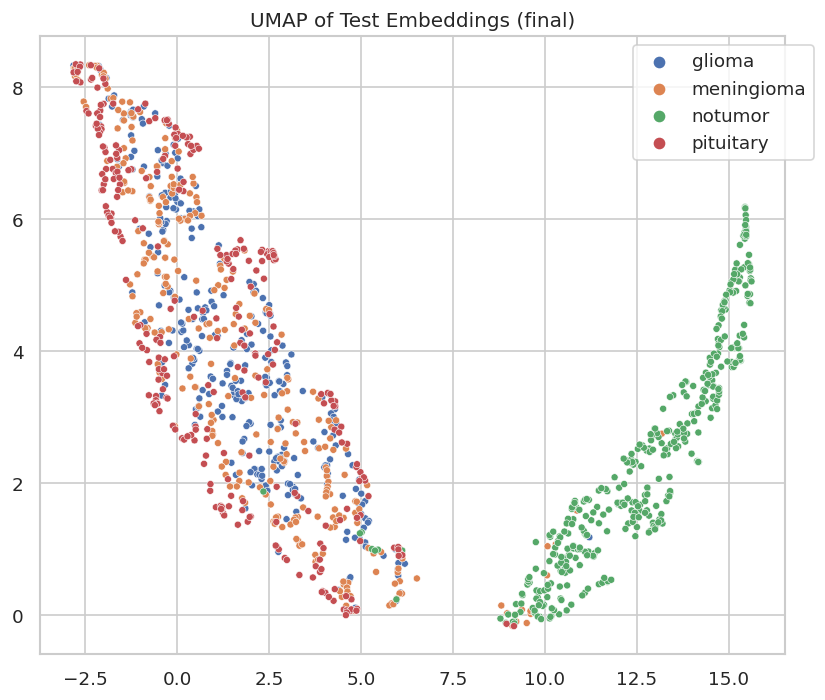

In [13]:
# 11) UMAP of penultimate features
# ----------------------------
def extract_features(model, loader, max_batches=50):
    model.eval()
    feats, labels = [], []
    with torch.no_grad():
        for i, (x,y) in enumerate(loader):
            x = x.to(device)
            f = model.forward_features(x)
            if isinstance(f, (list,tuple)): f = f[-1]
            if f.ndim > 2:
                f = f.mean(dim=(2,3))  # global pool if spatial
            feats.append(f.cpu().numpy())
            labels.extend(y.numpy())
            if i+1 >= max_batches: break
    return np.concatenate(feats, axis=0), np.array(labels)

feats, feat_labels = extract_features(final_model, test_loader, max_batches=50)
try:
    reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=SEED)
    emb = reducer.fit_transform(feats)
    plt.figure(figsize=(7,6))
    sns.scatterplot(x=emb[:,0], y=emb[:,1], hue=[class_names[i] for i in feat_labels], s=18)
    plt.title("UMAP of Test Embeddings (final)"); plt.legend(bbox_to_anchor=(1.05,1)); plt.tight_layout(); plt.show()
except Exception as e:
    print("UMAP step failed:", e)


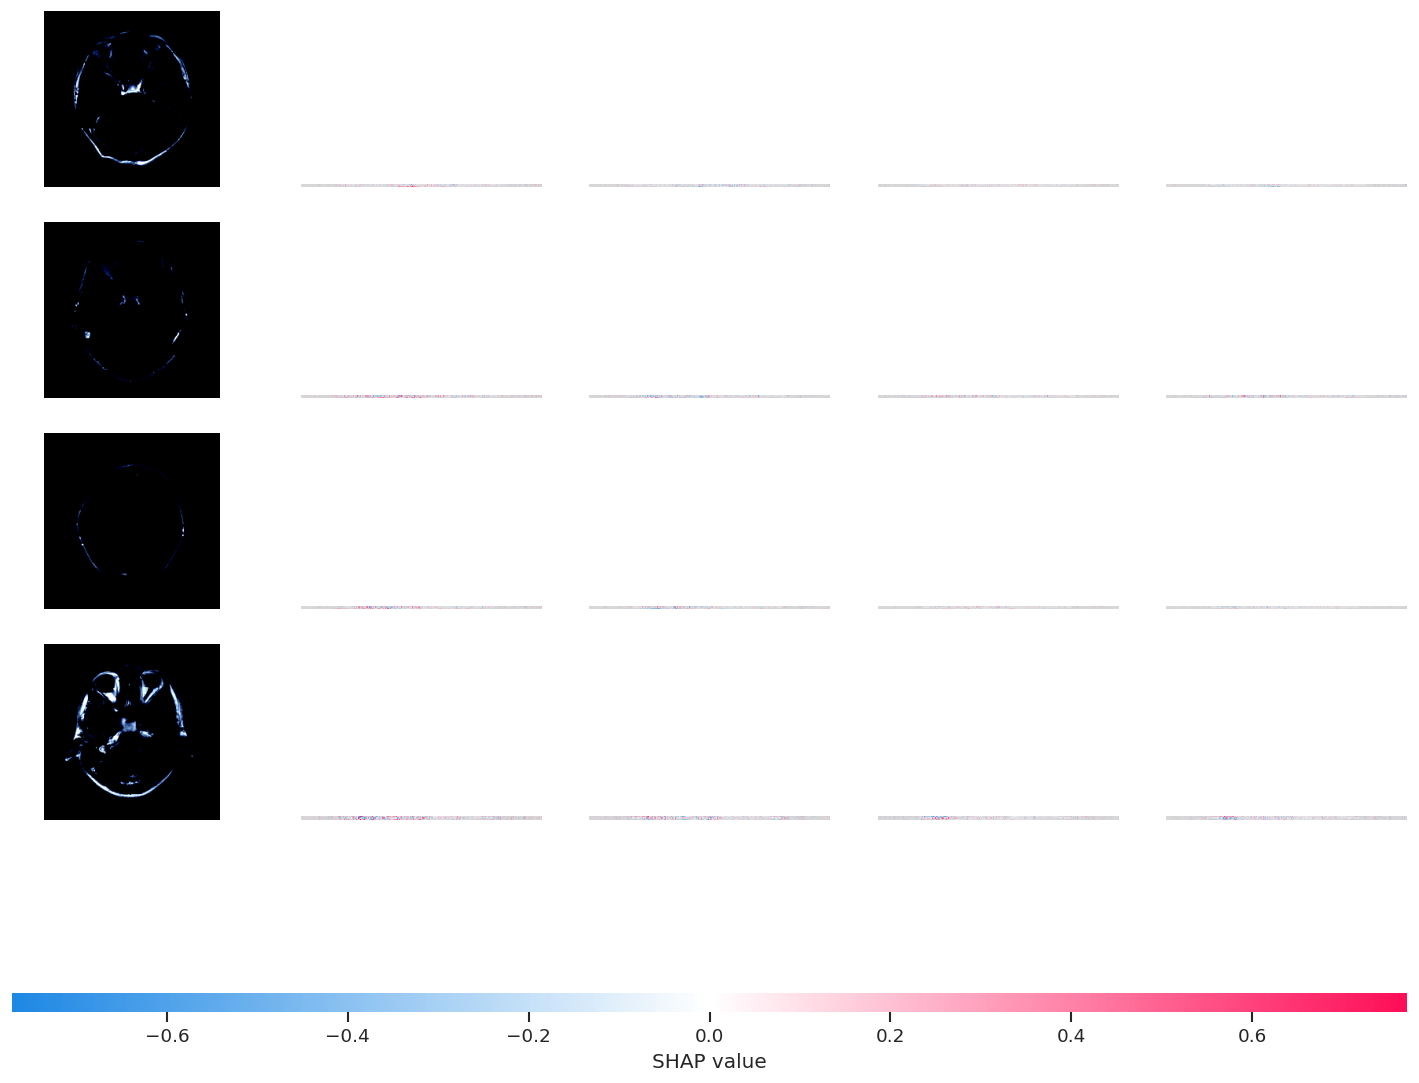

In [14]:
# 12) SHAP explainability (small background + few test images)
# ----------------------------
if shap is not None:
    try:
        final_model.eval()
        # background (small)
        bg_list = []
        for xb, _ in train_loader:
            bg_list.append(xb)
            if sum(t.size(0) for t in bg_list) >= 16: break
        background = torch.cat(bg_list, dim=0)[:16].to(device)

        test_batch, test_lbls = next(iter(test_loader))
        test_batch = test_batch[:4].to(device)

        # Attempt DeepExplainer, fallback to GradientExplainer
        try:
            explainer = shap.DeepExplainer(final_model, background)
            shap_vals = explainer.shap_values(test_batch)
        except Exception:
            explainer = shap.GradientExplainer(final_model, background)
            shap_vals = explainer.shap_values(test_batch)

        img_np = test_batch.cpu().permute(0,2,3,1).numpy()
        try:
            shap.image_plot(shap_vals, img_np)
        except Exception:
            # fallback visualization
            preds_test = final_model(test_batch).argmax(1).cpu().numpy()
            for i in range(len(test_batch)):
                cls = preds_test[i]
                sv = shap_vals[cls][i].transpose(1,2,0)
                img = img_np[i]
                plt.figure(figsize=(8,4))
                plt.subplot(1,2,1); plt.imshow(img); plt.title(f"Input - Pred {class_names[cls]}"); plt.axis("off")
                plt.subplot(1,2,2); plt.imshow(np.abs(sv).sum(-1)); plt.title("SHAP |sum|"); plt.axis("off")
                plt.tight_layout(); plt.show()
    except Exception as e:
        print("SHAP step failed:", e)
else:
    print("SHAP not available; skipped SHAP.")

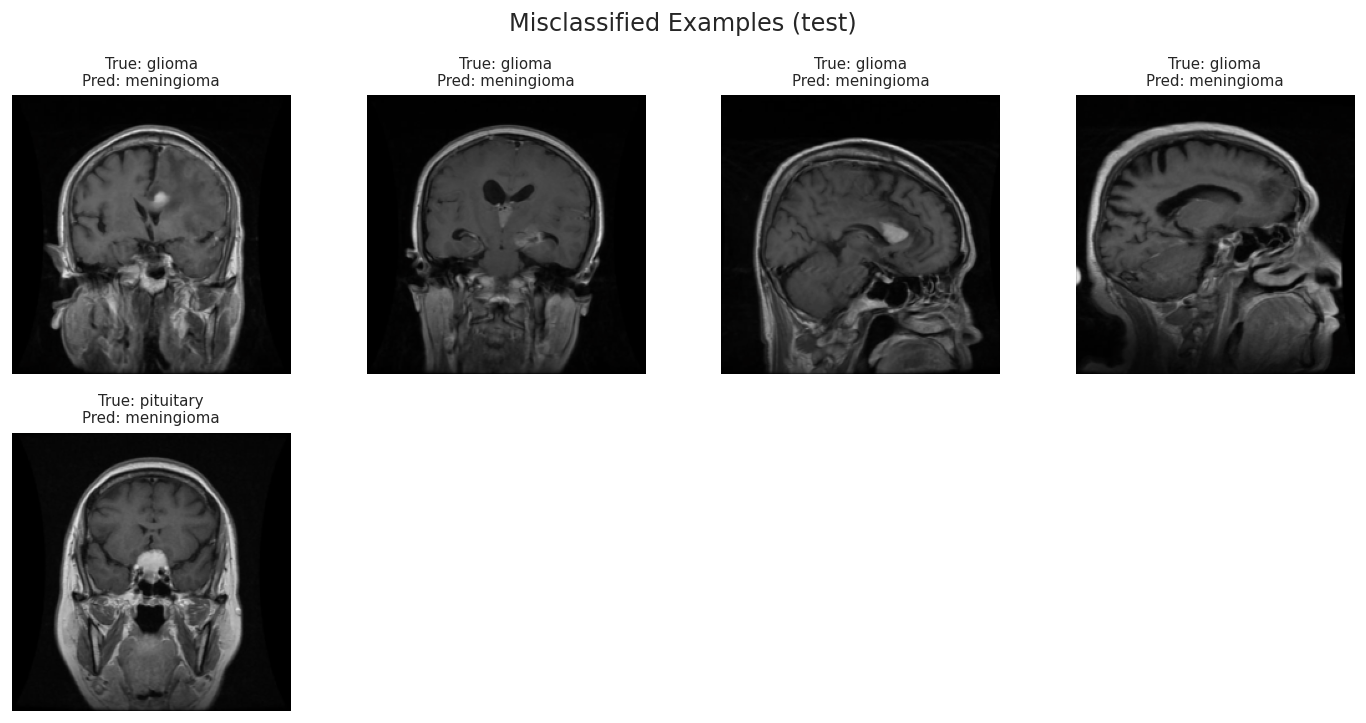

In [15]:
# 13) Misclassified gallery (if any)
# ----------------------------
@torch.no_grad()
def collect_all_preds(model, loader):
    model.eval()
    imgs_all, preds_all, labels_all = [], [], []
    for imgs, labels in loader:
        imgs = imgs.to(device)
        outs = model(imgs)
        preds = outs.argmax(1).cpu()
        imgs_all.append(imgs.cpu())
        preds_all.append(preds)
        labels_all.append(labels)
    return torch.cat(imgs_all), torch.cat(preds_all), torch.cat(labels_all)

imgs_all, preds_all, labels_all = collect_all_preds(final_model, test_loader)
mis_idx = (preds_all != labels_all).nonzero(as_tuple=True)[0]
n_show = min(12, mis_idx.size(0))
if n_show > 0:
    mean = torch.tensor(IMAGENET_MEAN)[:,None,None]
    std  = torch.tensor(IMAGENET_STD)[:,None,None]
    plt.figure(figsize=(12,9))
    for i in range(n_show):
        idx = int(mis_idx[i])
        img = imgs_all[idx] * std + mean
        img = img.clamp(0,1).permute(1,2,0).numpy()
        plt.subplot(3,4,i+1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"True: {class_names[labels_all[idx].item()]}\nPred: {class_names[preds_all[idx].item()]}", fontsize=9)
    plt.suptitle("Misclassified Examples (test)"); plt.tight_layout(); plt.show()
else:
    print("No misclassifications found (in collected test subset).")


In [16]:
# 14) Save final model
# ----------------------------
FINAL_CKPT = "final_swin_tiny_224_seed42_balanced.pth"
torch.save(final_model.state_dict(), FINAL_CKPT)
print("Saved final model to:", FINAL_CKPT)


Saved final model to: final_swin_tiny_224_seed42_balanced.pth


In [17]:
# 15) Final prediction helper (place your image path here)
# ----------------------------
def predict(img_path, model=final_model, transform=test_transform, class_names=class_names):
    model.eval()
    img = Image.open(img_path).convert("RGB")
    # show input
    plt.figure(figsize=(4,4)); plt.imshow(img); plt.axis("off"); plt.title("Input MRI"); plt.show()
    x = transform(img).unsqueeze(0).to(device)
    with torch.no_grad():
        logits = model(x)
        probs = torch.softmax(logits, dim=1).cpu().numpy()[0]
        pred_idx = int(np.argmax(probs))
    pred_class = class_names[pred_idx]
    conf = float(probs[pred_idx])

    # probability bar chart
    plt.figure(figsize=(7,3))
    sns.barplot(x=class_names, y=probs)
    plt.ylim(0,1); plt.title(f"Predicted: {pred_class} (conf={conf:.3f})"); plt.xticks(rotation=20)
    plt.tight_layout(); plt.show()

    print(f"✅ Predicted class: {pred_class} | confidence: {conf:.4f}")
    return pred_class, conf, probs


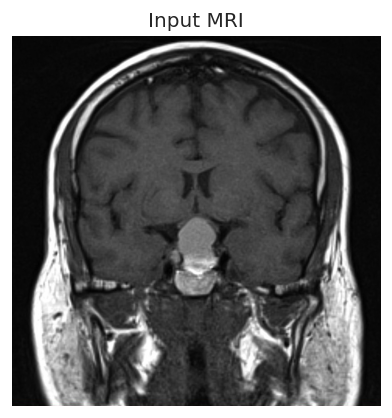

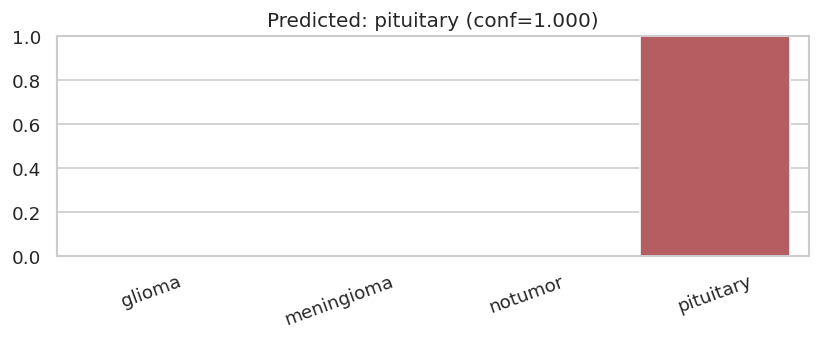

✅ Predicted class: pituitary | confidence: 0.9999


('pituitary',
 0.9998972415924072,
 array([8.8704532e-08, 9.0058433e-07, 1.0173989e-04, 9.9989724e-01],
       dtype=float32))

In [18]:
new_image_path = "/kaggle/input/final-test-images/PituitaryAdenoma.jpeg"
predict(new_image_path)

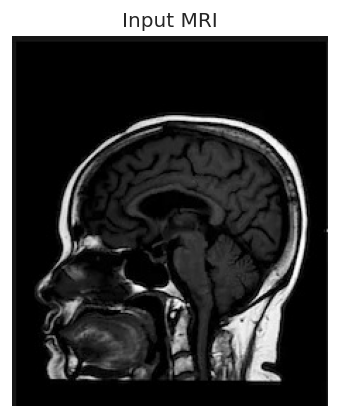

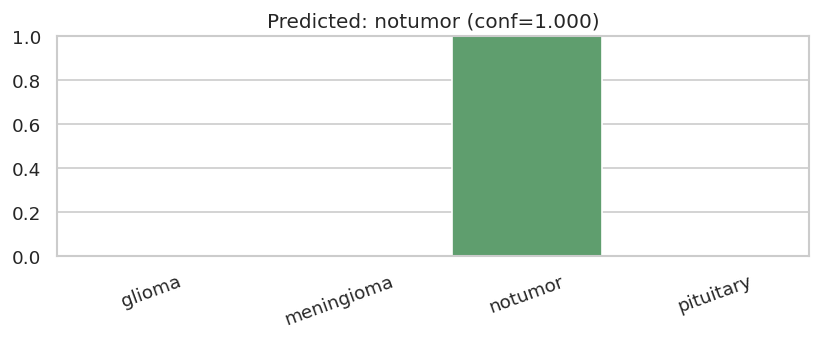

✅ Predicted class: notumor | confidence: 1.0000


('notumor',
 0.9999997615814209,
 array([5.7421636e-09, 1.9653730e-07, 9.9999976e-01, 1.6629896e-08],
       dtype=float32))

In [19]:
new_image_path = "/kaggle/input/brain-tumor-mri-dataset/Testing/notumor/Te-noTr_0004.jpg"
predict(new_image_path)

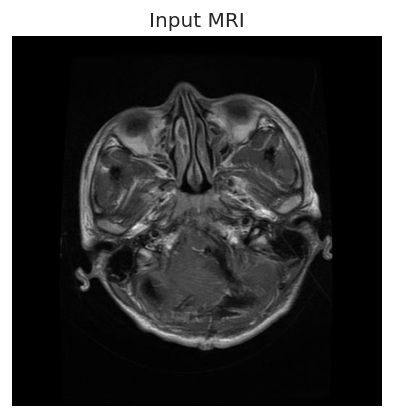

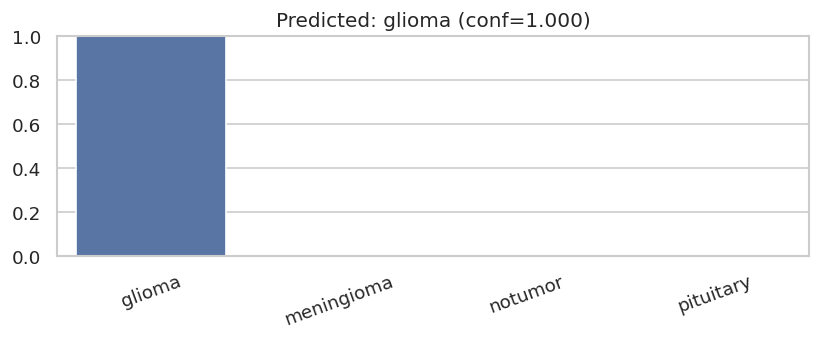

✅ Predicted class: glioma | confidence: 1.0000


('glioma',
 0.9999982118606567,
 array([9.9999821e-01, 2.5618972e-08, 1.7234131e-06, 1.1076810e-07],
       dtype=float32))

In [20]:
new_image_path = "/kaggle/input/brain-tumor-mri-dataset/Testing/glioma/Te-gl_0024.jpg"
predict(new_image_path)

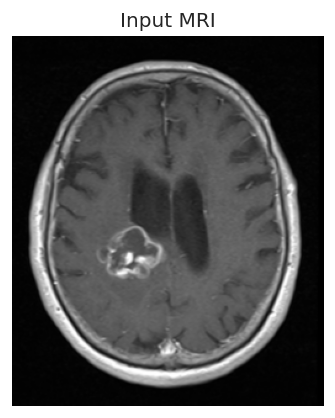

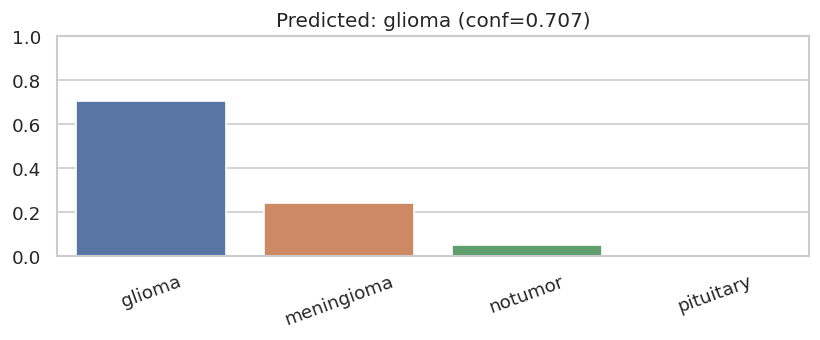

✅ Predicted class: glioma | confidence: 0.7070


('glioma',
 0.707039475440979,
 array([7.0703948e-01, 2.4324028e-01, 4.9592704e-02, 1.2761065e-04],
       dtype=float32))

In [21]:
new_image_path = "/kaggle/input/final-test-images/glomia.png"
predict(new_image_path)

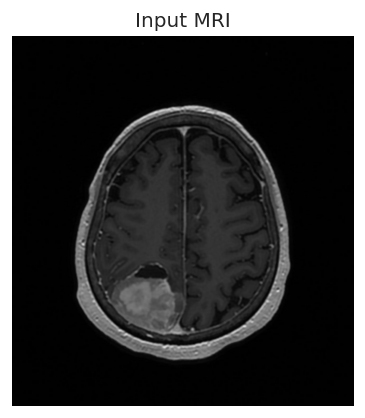

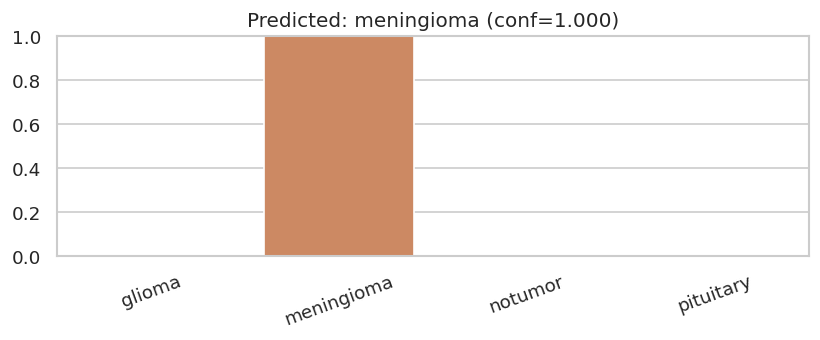

✅ Predicted class: meningioma | confidence: 1.0000


('meningioma',
 0.9999997615814209,
 array([2.0611337e-07, 9.9999976e-01, 3.6332178e-08, 1.3276653e-08],
       dtype=float32))

In [22]:
new_image_path = "/kaggle/input/final-test-images/meningioma-scan.jpg"
predict(new_image_path)

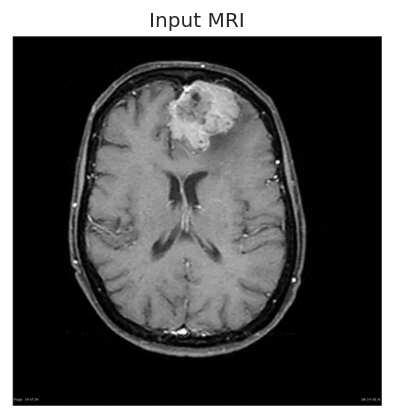

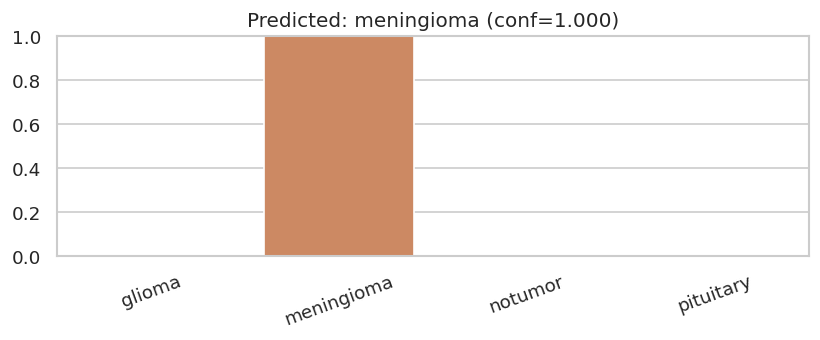

✅ Predicted class: meningioma | confidence: 1.0000


('meningioma',
 0.9999957084655762,
 array([5.0265094e-09, 9.9999571e-01, 4.1363924e-06, 1.5182762e-07],
       dtype=float32))

In [23]:
new_image_path = "/kaggle/input/test24/mening.webp"
predict(new_image_path)

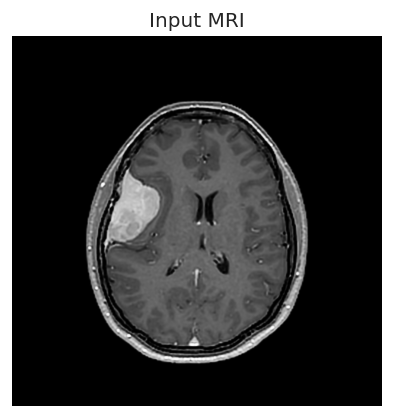

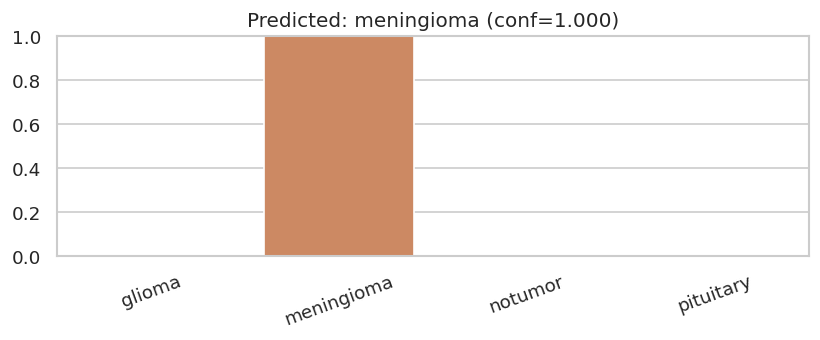

✅ Predicted class: meningioma | confidence: 1.0000


('meningioma',
 0.9999998807907104,
 array([1.1469251e-08, 9.9999988e-01, 5.0966602e-08, 1.1621165e-09],
       dtype=float32))

In [24]:
new_image_path = "/kaggle/input/jklbnm/rtt.jpeg"
predict(new_image_path)

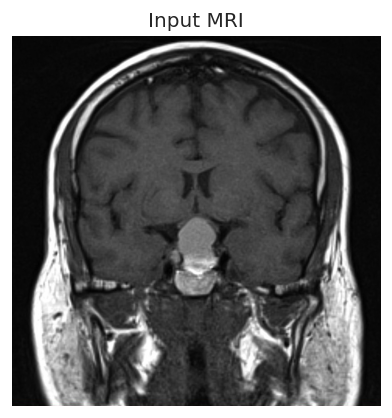

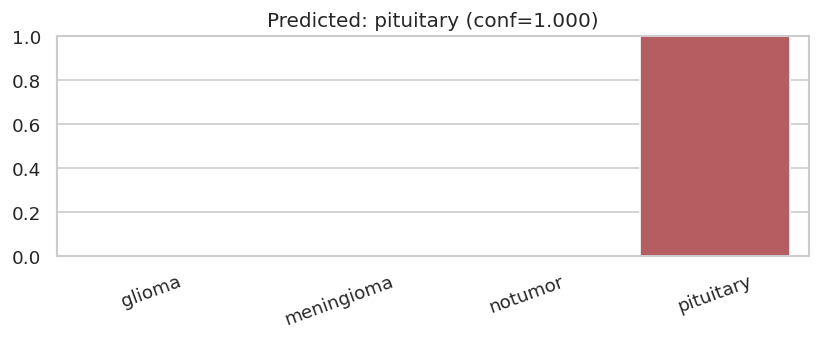

✅ Predicted class: pituitary | confidence: 0.9999


('pituitary',
 0.9998972415924072,
 array([8.8704532e-08, 9.0058433e-07, 1.0173989e-04, 9.9989724e-01],
       dtype=float32))

In [25]:
new_image_path = "/kaggle/input/pituitary/PituitaryAdenoma (1).jpeg"
predict(new_image_path)

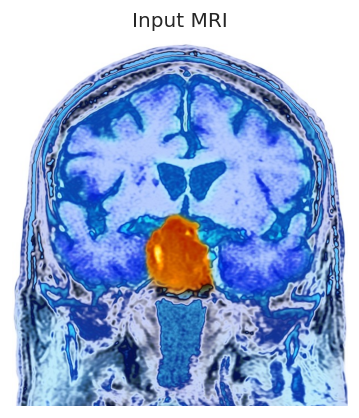

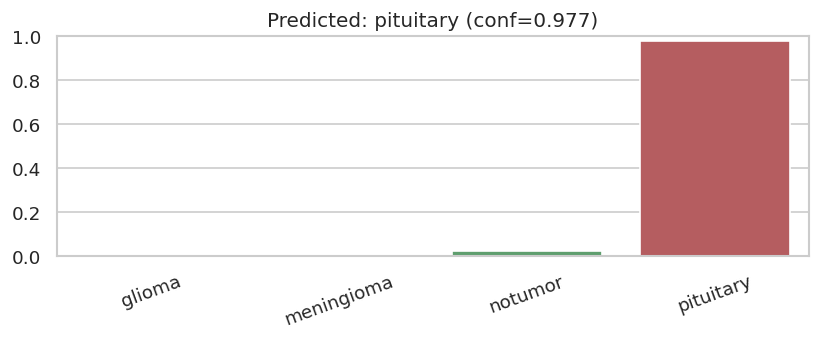

✅ Predicted class: pituitary | confidence: 0.9770


('pituitary',
 0.9769699573516846,
 array([2.3143188e-05, 1.3850541e-03, 2.1621790e-02, 9.7696996e-01],
       dtype=float32))

In [26]:
new_image_path = "/kaggle/input/pituitaryhhvgv/pituitary_adenoma_copy.jpg"
predict(new_image_path)